In [1]:
import sys
sys.path.append("../src")
sys.path.append("../data/embeddings")
import classifier
import debias
#import debias_old as debias
import gensim
import codecs
import json
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors
import numpy as np
import random
import sklearn
from sklearn import model_selection
from sklearn import cluster
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import SGDClassifier, Perceptron, LogisticRegression, PassiveAggressiveClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import scipy
from scipy import linalg
from scipy.stats.stats import pearsonr
import tqdm
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['agg.path.chunksize'] = 10000
from sklearn.utils import shuffle

#import warnings
#warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload

In [2]:
def tsne(vecs, labels, title="", ind2label = None, words = None, metric = "l2"):

  tsne = TSNE(n_components=2)#, angle = 0.5, perplexity = 20)
  vecs_2d = tsne.fit_transform(vecs)
  label_names = sorted(list(set(labels.tolist())))
  num_labels = len(label_names)

  names = sorted(set(labels.tolist()))

  plt.figure(figsize=(6, 5))
  colors = "red", "blue"
  for i, c, label in zip(sorted(set(labels.tolist())), colors, names):
     plt.scatter(vecs_2d[labels == i, 0], vecs_2d[labels == i, 1], c=c,
                label=label if ind2label is None else ind2label[label], alpha = 0.3, marker = "s" if i==0 else "o")
     plt.legend(loc = "upper right")

  plt.title(title)
  plt.savefig("embeddings.{}.png".format(title), dpi=600)
  plt.show()
  return vecs_2d

### Data loading & processing

In [3]:
def load_word_vectors(fname):
    
    model = KeyedVectors.load_word2vec_format(fname, binary=False)
    vecs = model.vectors
    words = list(model.vocab.keys())
    return model, vecs, words

def project_on_gender_subspaces(gender_vector, model: Word2VecKeyedVectors, n = 2500):
    
    group1 = model.similar_by_vector(gender_vector, topn = n, restrict_vocab=None)
    group2 = model.similar_by_vector(-gender_vector, topn = n, restrict_vocab=None)
    
    all_sims = model.similar_by_vector(gender_vector, topn = len(model.vectors), restrict_vocab=None)
    eps = 0.03
    idx = [i for i in range(len(all_sims)) if abs(all_sims[i][1]) < eps]
    samp = set(np.random.choice(idx, size = n))
    neut = [s for i,s in enumerate(all_sims) if i in samp]
    return group1, group2, neut

def get_vectors(word_list: list, model: Word2VecKeyedVectors):
    
    vecs = []
    for w in word_list:
        
        vecs.append(model[w])
    
    vecs = np.array(vecs)

    return vecs
    
def get_bias_by_neighbors(model, v, gender_direction, topn): 
    
    neighbors = model.similar_by_vector(v, topn = topn) 
    neighbors_words = [n for n, _ in neighbors]
    
    #bias = len([n for n in neighbors_words if n in gendered_words])
    bias = len([n for n in neighbors_words if model.cosine_similarities(model[n], [gender_direction])[0] > 0])
    bias /= (1.*topn)
    return bias


def save_in_word2vec_format(vecs: np.ndarray, words: np.ndarray, fname: str):


    with open(fname, "w", encoding = "utf-8") as f:

        f.write(str(len(vecs)) + " " + "300" + "\n")
        for i, (v,w) in tqdm.tqdm_notebook(enumerate(zip(vecs, words))):

            vec_as_str = " ".join([str(x) for x in v])
            f.write(w + " " + vec_as_str + "\n")

## Load word vectors

In [4]:
# 150k top vectors (with gender-typical words) - used for training

model, vecs, words = load_word_vectors(fname = "../data/embeddings/vecs.filtered.txt")

# only gendered vectors

model_gendered, _, _ = load_word_vectors(fname = "../data/embeddings/vecs.gendered.txt")


In [ ]:
def load_word_vectors(fname):
    
    model = KeyedVectors.load_word2vec_format(fname, binary=False)
    vecs = model.vectors
    words = list(model.vocab.keys())
    return model, vecs, words

# 150k top vectors (with gender-typical words) - used for training

model, vecs, words = load_word_vectors(fname = "../data/embeddings/vecs.filtered.txt")

gender_direction = model["he"]-model["she"] 

    group1 = model.similar_by_vector(gender_vector, topn = n, restrict_vocab=None)
    group2 = model.similar_by_vector(-gender_vector, topn = n, restrict_vocab=None)


In [ ]:
def project_on_gender_subspaces(gender_vector, model: Word2VecKeyedVectors, n = 2500):
    
    group1 = model.similar_by_vector(gender_vector, topn = n, restrict_vocab=None)
    group2 = model.similar_by_vector(-gender_vector, topn = n, restrict_vocab=None)
    
    all_sims = model.similar_by_vector(gender_vector, topn = len(model.vectors), restrict_vocab=None)
    eps = 0.03
    idx = [i for i in range(len(all_sims)) if abs(all_sims[i][1]) < eps]
    samp = set(np.random.choice(idx, size = n))
    neut = [s for i,s in enumerate(all_sims) if i in samp]
    return group1, group2, neut


## Collect biased words

In [5]:
num_vectors_per_class = 7500

by_pca = False
if by_pca:
    pairs = [("male", "female"), ("masculine", "feminine"), ("he", "she"), ("him", "her")]
    gender_vecs = [model[p[0]] - model[p[1]] for p in pairs]
    pca = PCA(n_components=1)
    pca.fit(gender_vecs)
    gender_direction = pca.components_[0]
    
else:
    gender_direction = model["he"]-model["she"] 


gender_unit_vec = gender_direction/np.linalg.norm(gender_direction)
masc_words_and_scores, fem_words_and_scores, neut_words_and_scores = project_on_gender_subspaces(gender_direction, model, n = num_vectors_per_class)

masc_words, masc_scores = list(zip(*masc_words_and_scores))
neut_words, neut_scores = list(zip(*neut_words_and_scores))
fem_words, fem_scores = list(zip(*fem_words_and_scores))
masc_vecs, fem_vecs = get_vectors(masc_words, model), get_vectors(fem_words, model)
neut_vecs = get_vectors(neut_words, model)

n = min(3000, num_vectors_per_class)
all_significantly_biased_words = masc_words[:n] + fem_words[:n]
all_significantly_biased_vecs =  np.concatenate((masc_vecs[:n], fem_vecs[:n]))
all_significantly_biased_labels = np.concatenate((np.ones(n, dtype = int),
                                                  np.zeros(n, dtype = int)))

all_significantly_biased_words, all_significantly_biased_vecs, all_significantly_biased_labels = sklearn.utils.shuffle(
all_significantly_biased_words, all_significantly_biased_vecs, all_significantly_biased_labels)
#print(np.random.choice(masc_words, size = 75))
print("TOP MASC")
print(masc_words[:50])
#print("LAST MASC")
#print(masc_words[-120:])
print("-------------------------")
#print(np.random.choice(fem_words, size = 75))
print("TOP FEM")
print(fem_words[:50])
#print("LAST FEM")
#print(fem_words[-120:])
print("-------------------------")
#print(np.random.choice(neut_words, size = 75))
print(neut_words[:50])


TOP MASC
('drafted', 'qb', 'soriano', 'himself', 'cardinals', 'giants', 'he', 'bullpen', 'sabean', 'jagr', 'muhammad', 'alou', 'rangers', 'defensive', 'draft', 'belichick', 'rookie', 'ratzinger', 'obp', 'santonio', 'muhammed', 'yankees', 'outfielder', 'preached', 'playmaker', 'lineman', 'offensive', 'wr', 'steelers', 'redskins', 'rushers', 'his', 'punter', 'anquan', 'boldin', 'bochy', 'caesarea', 'nfl', 'umenyiora', 'laurinaitis', 'flacco', 'rc', 'eusebius', 'packers', 'lhp', 'homers', 'mitre', 'linebacker', 'rhp', 'manny')
-------------------------
TOP FEM
('nichole', 'ftv', 'renee', 'sophie', 'christina', 'marie', 'pregnant', 'nicole', 'samantha', 'denise', 'sassy', 'madeline', 'alicia', 'lynette', 'xoxo', 'melanie', 'michelle', 'missy', 'kimberly', 'melissa', 'kayla', 'angelina', 'kristin', 'jennifer', 'emma', 'katie', 'pregnancy', 'jessica', 'heidi', 'tina', 'mandy', 'erika', 'maggie', 'shes', 'elaine', 'julie', 'vanessa', 'actress', 'leanne', 'kristina', 'faye', 'alexandra', 'tany

In [6]:
print(masc_scores[:10])
print(masc_scores[-10:])
print(neut_scores[:10])

(0.3077116906642914, 0.2944546043872833, 0.2902606725692749, 0.2880435585975647, 0.28346988558769226, 0.2792784869670868, 0.27867886424064636, 0.2778513729572296, 0.2777228057384491, 0.2761598825454712)
(0.12253306061029434, 0.1225176751613617, 0.1225091889500618, 0.1225038692355156, 0.12250120937824249, 0.12250052392482758, 0.12249962985515594, 0.12249766290187836, 0.12249290198087692, 0.12249206751585007)
(0.029992904514074326, 0.02998550981283188, 0.029980672523379326, 0.02998044341802597, 0.029976919293403625, 0.029973600059747696, 0.02996787615120411, 0.0299593023955822, 0.029956789687275887, 0.029918069019913673)


# 1. Dataset

## 1.1 Load Directly from saved

In [7]:
saved_dataset = np.load("../data/saved_models/general/all.npz")
X_dev = saved_dataset['x_dev']
X_train = saved_dataset['x_train']
X_test = saved_dataset['x_test']

Y_dev = saved_dataset['y_p_dev']
Y_train = saved_dataset['y_p_train']
Y_test = saved_dataset['y_p_test']

# Y_dev_label = Y_dev
# Y_train_label = Y_train
# Y_test_label = Y_test

Y_dev_2d = np.asarray([Y_dev, -Y_dev + 1]).T
Y_train_2d = np.asarray([Y_train, -Y_train + 1]).T
Y_test_2d = np.asarray([Y_test, -Y_test + 1]).T

## 1.2 Create the dataset Skip if load from saved 

## Perform train-dev-test split

In [42]:
random.seed(0)
np.random.seed(0)

X = np.concatenate((masc_vecs, fem_vecs), axis = 0)
#X = (X - np.mean(X, axis = 0, keepdims = True)) / np.std(X, axis = 0)
y_masc = np.ones(masc_vecs.shape[0], dtype = int)
y_fem = np.zeros(fem_vecs.shape[0], dtype = int)
#y = np.concatenate((masc_scores, fem_scores, neut_scores))#np.concatenate((y_masc, y_fem))
y = np.concatenate((y_masc, y_fem))
X_train_dev, X_test, y_train_dev, Y_test = sklearn.model_selection.train_test_split(X, y, test_size = 0.3, random_state = 0)
X_train, X_dev, Y_train, Y_dev = sklearn.model_selection.train_test_split(X_train_dev, y_train_dev, test_size = 0.3, random_state = 0)
print("Train size: {}; Dev size: {}; Test size: {}".format(X_train.shape[0], X_dev.shape[0], X_test.shape[0]))

Train size: 7350; Dev size: 3150; Test size: 4500


In [43]:
# remove neutral class, keep only male and female biased

X_dev = X_dev[Y_dev != -1]
X_train = X_train[Y_train != -1]
X_test = X_test[Y_test != -1]


Y_dev = Y_dev[Y_dev != -1]
Y_train = Y_train[Y_train != -1]
Y_test = Y_test[Y_test != -1]

print("Train size: {}; Dev size: {}; Test size: {}".format(X_train.shape[0], X_dev.shape[0], X_test.shape[0]))

Train size: 7350; Dev size: 3150; Test size: 4500


In [44]:
X_dev = np.asarray(X_dev)
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)

Y_dev = np.asarray(Y_dev)
Y_train = np.asarray(Y_train)
Y_test = np.asarray(Y_test)

# Y_dev_label = Y_dev
# Y_train_label = Y_train
# Y_test_label = Y_test


In [47]:
# Save
np.savez("../data/saved_models/general/all.npz", x_train = X_train, x_dev = X_dev, x_test = X_test, y_p_train = Y_train, y_p_dev = Y_dev, y_p_test = Y_test)

## 2 Debiasing

In [8]:
Y_train.shape

(7350,)

In [9]:
import time

In [10]:
start = time.time()
A = np.dot(X_train.T, Y_train_2d) / X_train.shape[0]
u, s, vh = np.linalg.svd(A, full_matrices=True)
print("time: {}".format(time.time() - start))
print(f"u has shape {u.shape}, s has shape {s.shape}, vh has shape {vh.shape}")

time: 0.024875879287719727
u has shape (300, 300), s has shape (2,), vh has shape (2, 2)


## Save model

In [11]:
np.savez("../data/saved_models/general/USV.npz", u = u, s = s, vh = vh)

## Load model

In [9]:
saved_model = np.load("../data/saved_models/general/USV.npz")
u = saved_model['u']
s = saved_model['s']
vh = saved_model['vh']

### Example: Update U to minimize the correlation

In [11]:
r = 2
u_r = u[:, r:]

In [17]:
proj = u_r @ u_r.T
X_debiased = proj.dot(X_train.T).T
print(f"{X_debiased.shape}")

(7350, 300)


# Test 1.1 : Perform the T-SNE test on different level of removal

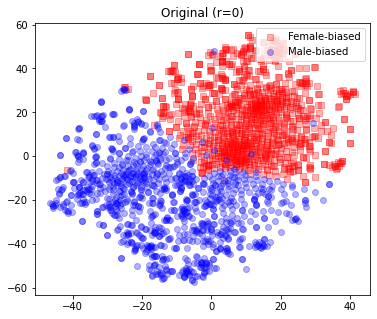

u_r has the shape of (300, 298)


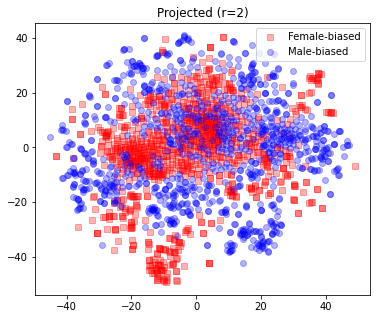

V-measure-before (TSNE space): 0.7238705067634674
V-measure-after (TSNE space): 0.004238804751062806
V-measure-before (original space): 1.0
V-measure-after (original space): 0.0005728149041390694
Rank before: 300; Rank after: 298


In [12]:
# def perform_purity_test(vecs, k, labels_true):
#         np.random.seed(0)
#         clustering = sklearn.cluster.KMeans(n_clusters = k)
#         clustering.fit(vecs)
#         labels_pred = clustering.labels_
#         score = sklearn.metrics.homogeneity_score(labels_true, labels_pred)
#         return score

def compute_v_measure(vecs, labels_true, k=2):
    
        np.random.seed(0)
        clustering = sklearn.cluster.KMeans(n_clusters = k)
        clustering.fit(vecs)
        labels_pred = clustering.labels_
        return sklearn.metrics.v_measure_score(labels_true, labels_pred)
    

# remove neutral class, keep only male and female biased

# X_dev = X_dev[Y_dev != -1]
# X_train = X_train[Y_train != -1]
# X_test = X_test[Y_test != -1]


# Y_dev = Y_dev[Y_dev != -1]
# Y_train = Y_train[Y_train != -1]
# Y_test = Y_test[Y_test != -1]


M =  2000
ind2label =  {1: "Male-biased", 0: "Female-biased"}
#tsne_before = tsne(all_significantly_biased_vecs[:M], all_significantly_biased_labels[:M], title = "Original (t=0)", ind2label =ind2label )
tsne_before = tsne(all_significantly_biased_vecs[:M], all_significantly_biased_labels[:M], title = "Original (r=0)", ind2label =ind2label )

r = 2
u_r = u[:, r:]
print(f"u_r has the shape of {u_r.shape}")
proj = u_r @ u_r.T
X_dev_cleaned = proj.dot(X_dev.T).T
X_test_cleaned = proj.dot(X_test.T).T
X_trained_cleaned = proj.dot(X_train.T).T
all_significantly_biased_cleaned = proj.dot(all_significantly_biased_vecs.T).T

#tsne_after = tsne_by_gender(all_significantly_biased_cleaned[:M], all_significantly_biased_labels[:M], title = "Projected (t = {})".format(n))
tsne_after = tsne(all_significantly_biased_cleaned[:M], all_significantly_biased_labels[:M], title = "Projected (r={})".format(r), ind2label =ind2label )

#tsne_projection = tsne_by_gender(all_biased_cleaned, all_significantly_biased_labels,title = "after (all)", words = all_significantly_biased_words)

print("V-measure-before (TSNE space): {}".format(compute_v_measure(tsne_before, all_significantly_biased_labels[:M])))
print("V-measure-after (TSNE space): {}".format(compute_v_measure(tsne_after, all_significantly_biased_labels[:M])))

#print("V-measure-before (original space): {}".format(compute_v_measure(all_significantly_biased_vecs[:M], all_significantly_biased_labels[:M]), k = 2))
#print("V-measure-after (original space): {}".format(compute_v_measure(all_significantly_biased_cleaned[:M], all_significantly_biased_labels[:M]), k = 2))
print("V-measure-before (original space): {}".format(compute_v_measure(all_significantly_biased_vecs[:M], all_significantly_biased_labels[:M]), k = 2))
print("V-measure-after (original space): {}".format(compute_v_measure(X_test_cleaned[:M], Y_test[:M]), k = 2))

rank_before = np.linalg.matrix_rank(X_train)
rank_after = np.linalg.matrix_rank(X_trained_cleaned)
print("Rank before: {}; Rank after: {}".format(rank_before, rank_after))

u_r has the shape of (300, 300)


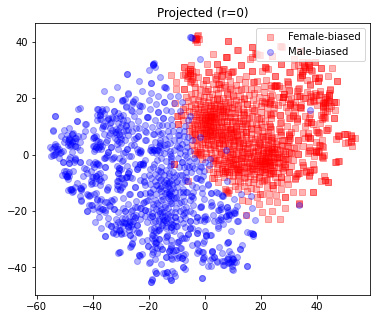

u_r has the shape of (300, 299)


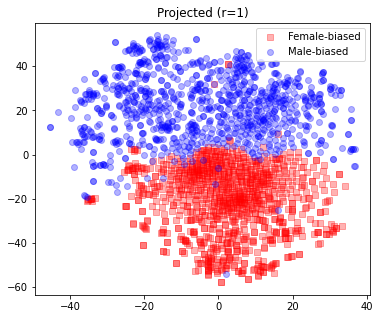

u_r has the shape of (300, 298)


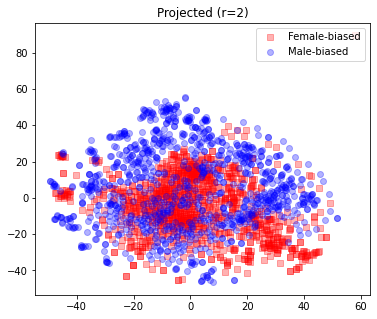

u_r has the shape of (300, 297)


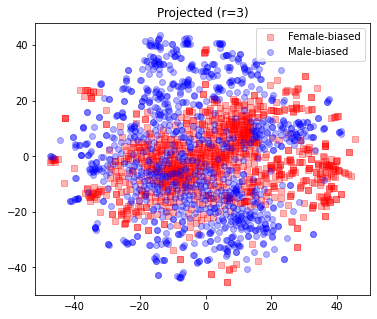

In [11]:
M =  2000

for r in [0, 1, 2]:
    u_r = u[:, r:]
    print(f"u_r has the shape of {u_r.shape}")
    proj = u_r @ u_r.T
    tsne_after = tsne(proj.dot(all_significantly_biased_vecs[:M].T).T , all_significantly_biased_labels[:M], title = "Projected (r={})".format(r), ind2label =ind2label )

u_r has the shape of (300, 300)


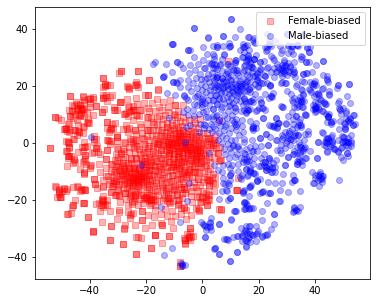

u_r has the shape of (300, 299)


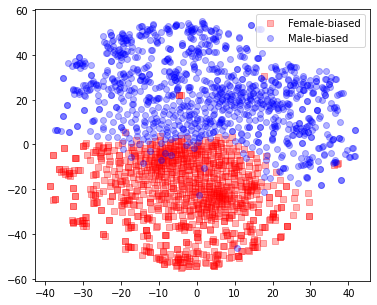

u_r has the shape of (300, 298)


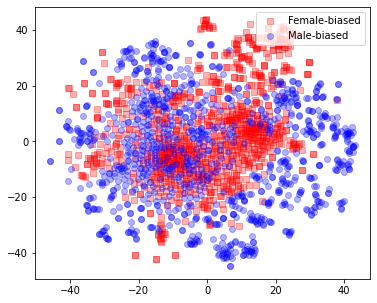

In [13]:
M =  2000

for r in [0, 1, 2]:
    u_r = u[:, r:]
    print(f"u_r has the shape of {u_r.shape}")
    proj = u_r @ u_r.T
    tsne_after = tsne(proj.dot(all_significantly_biased_vecs[:M].T).T , all_significantly_biased_labels[:M], ind2label =ind2label )

# Test 1.2 Gender prediction by linear and non-linear classifier

In [13]:
"""
    The Y_train has been transformed to 1D to fit with the classifier, what if we define it to be 
"""


"""
nonlinear_clf = SVC(kernel = "rbf")
print("Before, rbf-svm:")
nonlinear_clf.fit(X_train, Y_train)
print(nonlinear_clf.score(X_dev, Y_dev))

""" 


# for r in [1, 2, 3]:
for r in [1, 2, 3]:

    u_r = u[:, r:]
    proj = u_r @ u_r.T
    X_dev_cleaned = proj.dot(X_dev.T).T
    X_test_cleaned = proj.dot(X_test.T).T
    X_trained_cleaned = proj.dot(X_train.T).T
    
    print(f"============== remove {r} canonical components ==============")
    print("Before, linear:")
    linear_clf = LinearSVC(dual=False, max_iter = 1500)
    linear_clf.fit(X_train, Y_train)
    print(f"X_test_cleaned score: {linear_clf.score(X_test, Y_test)}")

    print("After, linear:")
    linear_clf = LinearSVC(dual=False, max_iter = 1500)
    linear_clf.fit(X_trained_cleaned, Y_train)
    print(f"X_test_cleaned score: {linear_clf.score(X_test_cleaned, Y_test)}, \
          X_dev_cleaned score: {linear_clf.score(X_dev_cleaned, Y_dev)}")

    print("After, rbf-svm:")
    nonlinear_clf = SVC(kernel = "rbf")
    nonlinear_clf.fit(X_trained_cleaned, Y_train)
    print(f"X_dev_cleaned score: {nonlinear_clf.score(X_dev_cleaned, Y_dev)}")

    print("After, mlp:")
    nonlinear_clf = MLPClassifier(hidden_layer_sizes = 256, activation = "relu")
    nonlinear_clf.fit(X_trained_cleaned, Y_train)
    print(f"X_dev_cleaned score: {nonlinear_clf.score(X_dev_cleaned, Y_dev)}")

============== remove 1 canonical components ==============
Before, linear:
X_test_cleaned score: 1.0
After, linear:
X_test_cleaned score: 1.0,           X_dev_cleaned score: 1.0
After, rbf-svm:
X_dev_cleaned score: 1.0
After, mlp:
X_dev_cleaned score: 1.0
============== remove 2 canonical components ==============
Before, linear:
X_test_cleaned score: 1.0
After, linear:
X_test_cleaned score: 0.49422222222222223,           X_dev_cleaned score: 0.4946031746031746
After, rbf-svm:
X_dev_cleaned score: 0.9676190476190476
After, mlp:
X_dev_cleaned score: 0.966984126984127
============== remove 3 canonical components ==============
Before, linear:
X_test_cleaned score: 1.0
After, linear:
X_test_cleaned score: 0.49422222222222223,           X_dev_cleaned score: 0.4946031746031746
After, rbf-svm:
X_dev_cleaned score: 0.9682539682539683
After, mlp:
X_dev_cleaned score: 0.9704761904761905


<font color='darkorchid' size=5>Interesting fact that whatever we remove from the canonical components, it can still be recoverable from non-linear calssifier</font>

# Test 1.3 Project on the gender direction

In [14]:
r = 2
u_r = u[:, r:]
proj = u_r @ u_r.T
masc_vecs_cleaned = proj.dot(masc_vecs.T).T
fem_vecs_cleaned = proj.dot(fem_vecs.T).T

print("masc-bias-before: {}".format(masc_vecs.dot(gender_unit_vec).mean()))
print("masc-bias-after: {}".format(masc_vecs_cleaned.dot(gender_unit_vec.dot(proj)).mean()))
print("fem-bias-before: {}".format(fem_vecs.dot(gender_unit_vec).mean()))
print("fem-bias-after: {}".format(fem_vecs_cleaned.dot(gender_unit_vec.dot(proj)).mean()))

masc-bias-before: 1.0073015689849854
masc-bias-after: 0.003109228071241853
fem-bias-before: -0.9732301831245422
fem-bias-after: -0.001174279573870251


# SAVE THE RESULTS

In [17]:
# r is the number of canonical components to remove
r = 2
u_r = u[:, r:]
proj = u_r @ u_r.T

vecs_cleaned = proj.dot(vecs.T).T
save_in_word2vec_format(vecs_cleaned, words, "../data/embeddings/vecs.cca.cleaned.txt")

/lustre/home/sc066/shunshao/miniconda3/envs/cca/lib/python3.7/site-packages/ipykernel_launcher.py:48: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

In [18]:
model_cleaned, _, _ = load_word_vectors(fname = "../data/embeddings/vecs.cca.cleaned.txt")

# Test 1.4.1 calcualte the similarity of male-stereotyped and female-stereotyped words to 'girlish', before and after

In [19]:
w = "girlish"
k = 5000

random_fem_words = np.random.choice(fem_words, size = k)
sim_to_girlish_before = [model.similarity(w,w2) for w2 in random_fem_words]
sim_to_girlish_after = [model_cleaned.similarity(w,w2) for w2 in random_fem_words]

print("Similarity of female-stereotyped words to 'girlish' before: {}; similarity after: {}".format(np.mean(sim_to_girlish_before), np.mean(sim_to_girlish_after)))


w = "girlish"
random_masc_words = np.random.choice(masc_words, size = k)
sim_to_girlish_before = [model.similarity(w,w2) for w2 in random_masc_words]
sim_to_girlish_after = [model_cleaned.similarity(w,w2) for w2 in random_masc_words]

print("Similarity of male-stereotyped words to 'girlish' before: {}; similarity after: {}".format(np.mean(sim_to_girlish_before), np.mean(sim_to_girlish_after)))


Similarity of female-stereotyped words to 'girlish' before: 0.09480048716068268; similarity after: -8.931956108426675e-05
Similarity of male-stereotyped words to 'girlish' before: 0.010917985811829567; similarity after: 0.0012107666116207838


# Test 1.4.2 print the most similar words to random words before and after (to make sure we didn't damage the space too much)

In [20]:
from collections import defaultdict
import pickle

words_chosen = np.random.choice(words[:15000] , size = 40)
topn = 3
words_before_and_after = defaultdict(dict)
gendered_words_before_and_after = defaultdict(dict)

for w in words_chosen:
    words_and_sims_before = model.most_similar(w, topn = topn)
    words__and_sims_after = model_cleaned.most_similar(w, topn = topn)
    words_before, sims_before = zip(*words_and_sims_before)
    words_after, sims_after = zip(*words__and_sims_after)
    words_before_and_after[w]["before"] = words_before
    words_before_and_after[w]["after"] = words_after
    print("w: {}\n most-similar-before: {}\n most-similar-after: {}".format(w,words_before, words_after))
    print("----------------------------------")

print("====================================================================\n\n")
print("gendered words:")
words_chosen = ["miss", "mrs", "mr", "john", "rachel", "wife", "mom", "family", "father", "lady", "he", "she"]
words_chosen = ["ruth", "charlotte", "abigail", "sophie", "nichole", "emma", "olivia", "ava", "isabella", "sophia", "charlotte", "mia", "amelia",
                "james", "john", "robert", "michael", "william", "david", "richard", "joseph", "thomas", "ariel", "mike", "nurse", "mom", "secretary", "nursery"]
for w in words_chosen:
    
    words_and_sims_before = model.most_similar(w, topn = topn)
    words__and_sims_after = model_cleaned.most_similar(w, topn = topn)
    words_before, _ = zip(*words_and_sims_before)
    words_after, _ = zip(*words__and_sims_after)
    gendered_words_before_and_after[w]["before"] = words_before
    gendered_words_before_and_after[w]["after"] = words_after
    print("w: {}\n most-similar-before: {}\n most-similar-after: {}".format(w,words_before, words_after))
    print("----------------------------------")    
    
with open("words_before_and_after.pickle", "wb") as f:
    pickle.dump(words_before_and_after, f)
    
with open("words_before_and_after_gendered.pickle", "wb") as f:
    pickle.dump(gendered_words_before_and_after, f)

w: elaine
 most-similar-before: ('karen', 'kathy', 'joanne')
 most-similar-after: ('karen', 'kathy', 'carol')
----------------------------------
w: lobbying
 most-similar-before: ('lobbyists', 'lobbyist', 'campaigning')
 most-similar-after: ('lobbyists', 'lobbyist', 'campaigning')
----------------------------------
w: once
 most-similar-before: ('again', 'then', 'when')
 most-similar-after: ('again', 'then', 'when')
----------------------------------
w: romney
 most-similar-before: ('mitt', 'mccain', 'obama')
 most-similar-after: ('mitt', 'mccain', 'obama')
----------------------------------
w: parliament
 most-similar-before: ('parliamentary', 'mps', 'elections')
 most-similar-after: ('parliamentary', 'mps', 'elections')
----------------------------------
w: dashboard
 most-similar-before: ('dashboards', 'smf', 'powered')
 most-similar-after: ('dashboards', 'smf', 'powered')
----------------------------------
w: cumulative
 most-similar-before: ('gpa', 'accumulative', 'aggregate')
 mo

In [21]:
sims_before, sims_after

((0.8115034103393555, 0.7444023489952087, 0.7280417084693909),
 (0.8143391013145447, 0.7359080910682678, 0.7278944253921509))

# Test 1.5 bias by profession experiment

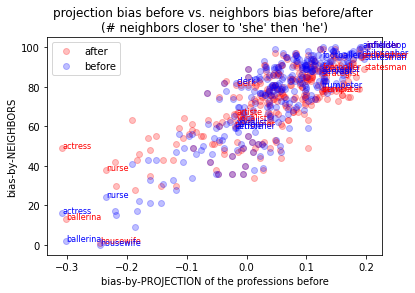

Correlation before: 0.8524125255370698, p-value: 2.2680766648262084e-83
Correlation after: 0.7484998774662416, p-value: 1.7326473393063508e-53


In [24]:
def get_bias_by_neighbors(model, model_cleaned, gendered_words, v, gender_direction): 
    
    neighbors = model_cleaned.similar_by_vector(v, topn=100) 
    neighbors_words = [n for n, _ in neighbors]
    
    #bias = len([n for n in neighbors_words if n in gendered_words])
    bias = len([n for n in neighbors_words if model.cosine_similarities(model[n], [gender_direction])[0] > 0])
    return bias

def bias_by_profession(model, model_cleaned, gender_direction, masc_words):
    
    with codecs.open("../data/lists/professions.json") as f:
        professions_and_scores = json.load(f)

    professions = [p[0] for p in professions_and_scores]
    #print(professions)
    professions = list(filter(lambda p: p in model, professions))
    vecs = np.array([model[p] for p in professions])
    r = 2
    u_r = u[:, r:]
    proj = u_r @ u_r.T
#     vecs_cleaned = vecs.dot(proj)
    vecs_cleaned = proj.dot(vecs.T).T
#     vecs_cleaned = vecs.dot(P)
    bias_vals = np.array([model.cosine_similarities(gender_direction,vecs)])[0]
    #bias_vals_after = np.array([model.cosine_similarities(gender_direction,vecs_cleaned)])[0]
    bias_by_neighbors_after = np.array([get_bias_by_neighbors(model, model_cleaned, masc_words, v, gender_direction) for v in vecs_cleaned])
    bias_by_neighbors_before = np.array([get_bias_by_neighbors(model, model, masc_words, v, gender_direction) for v in vecs])

    #plt.ylim([np.min(bias_vals), np.max(bias_vals)])
    plt.plot(bias_vals, bias_by_neighbors_after, marker = "o", linestyle = "none", color = "red", label = "after", alpha = 0.25)
    plt.plot(bias_vals, bias_by_neighbors_before, marker = "o", linestyle = "none", color = "blue", label = "before", alpha = 0.25)
    
    word_idx_high = np.argsort(bias_vals)[:4] 
    word_idx_low = np.argsort(bias_vals)[-4:]
    word_idx_middle_low = np.argsort(bias_vals)[-55:-51]
    word_idx_middle_high = np.argsort(bias_vals)[51:55]
    words_biased_fem = [professions[i] for i in word_idx_high]
    words_biased_masc = [professions[i] for i in word_idx_low]
    mid_low = [professions[i] for i in word_idx_middle_low]
    mid_high = [professions[i] for i in word_idx_middle_high]
    words = words_biased_masc + words_biased_fem + mid_low + mid_high
    
    for w in words:
        i = professions.index(w)
        x1,y1 = bias_vals[i],bias_by_neighbors_after[i]
        plt.annotate(w , (x1,y1), size = 8, color = "red")
        x2,y2 = bias_vals[i],bias_by_neighbors_before[i]
        plt.annotate(w, (x2,y2), size = 8, color = "blue")
        #plt.arrow(x2,y2,x1-x2,y1-y2, width = 0.0005)
        
    plt.legend()
    plt.xlabel("bias-by-PROJECTION of the professions before")
    plt.ylabel("bias-by-NEIGHBORS")
    plt.title("projection bias before vs. neighbors bias before/after \n(# neighbors closer to 'she' then 'he')")
    plt.show()
    
    print("Correlation before: {}, p-value: {}".format(*pearsonr(bias_vals, bias_by_neighbors_before)))
    print("Correlation after: {}, p-value: {}".format(*pearsonr(bias_vals, bias_by_neighbors_after)))

        
bias_by_profession(model, model_cleaned, gender_direction, None)

# Test 1.6 word association tests

In [25]:
# Auxiliary functions for experiments by Caliskan et al.

import scipy
import scipy.misc as misc
import itertools


def s_word(w, A, B, model, all_s_words):
    
    if w in all_s_words:
        return all_s_words[w]
    
    mean_a = []
    mean_b = []
    
    for a in A:
        mean_a.append(model.similarity(w,a))
    for b in B:
        mean_b.append(model.similarity(w,b))
        
    mean_a = sum(mean_a)/float(len(mean_a))
    mean_b = sum(mean_b)/float(len(mean_b))
    
    all_s_words[w] = mean_a - mean_b

    return all_s_words[w]


def s_group(X, Y, A, B, model, all_s_words):
    
    total = 0
    for x in X:
        x_sim = s_word(x, A, B, model, all_s_words)
        total += x_sim
    for y in Y:
        y_sim =  s_word(y, A, B, model, all_s_words)
        total -= y_sim
    
    #print(x_sim, y_sim)
        
    return total


def p_value_exhust(X, Y, A, B, model):
    
    if len(X) > 10:
        print ('might take too long, use sampled version: p_value')
        return
    
    assert(len(X) == len(Y))
    
    all_s_words = {}
    s_orig = s_group(X, Y, A, B, model, all_s_words)
    #print("s-orig: {}".format(s_orig))
    
    union = set(X+Y)
    subset_size = int(len(union)/2)
    
    larger = 0
    total = 0
    #all_subs = set(itertools.combinations(union, subset_size))
    #print(all_subs)
    for subset in tqdm.tqdm_notebook(set(itertools.combinations(union, subset_size))):
        total += 1
        Xi = list(set(subset))
        Yi = list(union - set(subset))
        if s_group(Xi, Yi, A, B, model, all_s_words) > s_orig:
            larger += 1
    #print ('num of samples', total)
    return larger/float(total)


def p_value_sample(X, Y, A, B, model):
    
    random.seed(10)
    np.random.seed(10)
    all_s_words = {}
    
    assert(len(X) == len(Y))
    length = len(X)
    
    s_orig = s_group(X, Y, A, B, model, all_s_words) 
    
    num_of_samples = min(10000, int(scipy.special.comb(length*2,length)*100))
    print ('num of samples', num_of_samples)
    larger = 0
    for i in range(num_of_samples):
        permute = np.random.permutation(X+Y)
        Xi = permute[:length]
        Yi = permute[length:]
        if s_group(Xi, Yi, A, B, model, all_s_words) > s_orig:
            larger += 1
    
    return larger/float(num_of_samples)

In [26]:
# Experiment 1

A = ['john', 'paul', 'mike', 'kevin', 'steve', 'greg', 'jeff', 'bill']
B = ['amy', 'joan', 'lisa', 'sarah', 'diana', 'kate', 'ann', 'donna']

C = ['executive', 'management', 'professional', 'corporation', 'salary', 'office', 'business', 'career']
D = ['home', 'parents', 'children', 'family', 'cousins', 'marriage', 'wedding', 'relatives']

print (p_value_exhust(A, B, C, D, model_cleaned))

# Experiment 2

E = ['math', 'algebra', 'geometry', 'calculus', 'equations', 'computation', 'numbers', 'addition']
F = ['poetry', 'art', 'dance', 'literature', 'novel', 'symphony', 'drama', 'sculpture']

print (p_value_exhust(A, B, E, F, model_cleaned))


# Experiment 3

G = ['science', 'technology', 'physics', 'chemistry', 'einstein', 'nasa', 'experiment', 'astronomy']
H = ['poetry', 'art', 'shakespeare', 'dance', 'literature', 'novel', 'symphony', 'drama']

print (p_value_exhust(A, B, G, H, model_cleaned))

/lustre/home/sc066/shunshao/miniconda3/envs/cca/lib/python3.7/site-packages/ipykernel_launcher.py:63: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/12870 [00:00<?, ?it/s]

0.06596736596736597


  0%|          | 0/12870 [00:00<?, ?it/s]

0.04825174825174825


  0%|          | 0/12870 [00:00<?, ?it/s]

0.10007770007770007
